In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

from sqlalchemy import create_engine
import seaborn as sns
from databasing.conn_strings import db_conn_string
import matplotlib.pyplot as plt
import ipywidgets as widgets

import matplotlib.mlab as ml
import numpy as np
import pandas as pd
from scipy.stats import signaltonoise

from databasing.database_pull import pull_data_by_lift
from processing.util import process_data


conn = create_engine(db_conn_string)
ts_figsize = (12, 5)  # default shape of any timeseries plots

In [2]:
def max_min_norm(x):
    return x/(max(x) - min(x))


def find_key_var(s):
    main_keys = [k.split('_')[0] for k in s.keys()]
    lab = [k for k in np.unique(main_keys) if k in ['a', 'v', 'pow', 'pos']][0]
    if lab == 'a':
        key_var = 'ACCELERATION'
    elif lab == 'v':
        key_var = 'VELOCITY'
    elif lab == 'pow':
        key_var = 'POWER'
    else:
        print('Unhandled key_var value {}'.format(lab))
        key_var = None
        
    return key_var
    
def print_stats(s, key_var):
    nn_keys = sorted([k for k in s.keys() if ('_norm' not in k) and (key_var.lower()[0] in k)])
    
    offsets = {k: round(s[k].mean(),6) for k in nn_keys}
    print 'mean: {}'.format(offsets)

    var = {k: round(s[k].var(),4) for k in nn_keys}
    print 'var:  {}'.format(var)

    snr = {k: round(s[k].mean()/s[k].std(), 4) for k in nn_keys}
    print 'SNR:  {}'.format(snr)
    
def build_keys(s, norm):
    colors = ['red', 'green', 'blue']
    norm_keys = sorted([k for k in s.keys() if '_norm' in k])
    nn_keys = sorted([k for k in s.keys() if '_norm' not in k])

    if norm:
        key_with_color = zip(colors, norm_keys)
    else:
        key_with_color = zip(colors, nn_keys)
    
    return key_with_color

def run_norms(a, v):
    # normalize accel
    for k in a.keys():
        key = k + '_norm'
        a[key] = max_min_norm(a[k])

    # normalize velocity
    for k in v.keys():
        key = k + '_norm'
        v[key] = max_min_norm(v[k])
        
    return a, v

# EXAMPLE run a single fft across entire signal
# returns power values p1 within frequencies f1
# p1, f1 = ml.psd(a['a_z'], nfft, 30., sides='onesided')
# plt.plot(f1, p1)
def run_windows(a, header):
    # build spectral estimate of signal
    nfft=2**4
    fs = float(header['sampling_rate'])  # sampling rate
    N = len(a['a_z'])  # number of samples
    w_size = int(fs)        # window size
    step_size = int(np.ceil(fs/3.))  # number of points to step window over
    n_steps = int(np.ceil(N/step_size))  # number of steps to cover entire signal, given step_size

    means = []
    variance = []
    dat = pd.DataFrame()
    for step in range(n_steps-1):
        acc = a['a_z'].iloc[(step*step_size):w_size + (step+1)*step_size]
        p, f = ml.psd(acc, nfft, fs, sides='onesided')
        dat = dat.append(pd.Series(p, index=f).T, ignore_index=True)
        means.append(acc.mean())
        variance.append(acc.var())

    dat = dat.applymap(np.log10)
    dat = dat.apply(lambda col: col - col.mean(), axis=0)
    dat.head()
    
    return dat, means, variance

In [3]:
def plot_ts(s, norm=True, stats=False):
    key_with_color = build_keys(s, norm)
        
    plt.figure(figsize=ts_figsize)
    for c, lab in key_with_color:
        plt.plot(data['timepoint'], s[lab], color=c, alpha=0.5, label=lab)

    key_var = find_key_var(s)
        
    # TODO - fix the SQL query
    i_reps, f_reps = header['init_num_reps'], header['final_num_reps']
    n_reps = f_reps if f_reps is not None else i_reps
    title = key_var + ' | ' + str(header['created_at'].date()) + ' | ' + header['lift_type'] + ' | ' + str(n_reps) + ' reps'
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Norm {} Magnitude (units)'.format(key_var.title()))
    _ = plt.legend()
    
    if stats:
        print_stats(s, key_var)
    
def plot_windows(a, means, variance):
    fig, axarr = plt.subplots(3, 1, figsize=(12, 9))
    axarr[0].plot(a.index, a['a_z'])
    axarr[0].set_xlim([0, len(a.index)])
    axarr[0].set_title('a_z plot')
    axarr[1].plot(variance)
    axarr[1].set_title('windowed variance signal')
    axarr[2].plot(means)
    axarr[2].set_title('windowed mean signal')

    print 'Variance of variance signal: {}'.format(np.var(variance))
    print 'Variance of means signal: {}'.format(np.var(means))
    
def plot_spectral(a, dat):
    fig, axarr = plt.subplots(2, 1, figsize=(12, 6))
    axarr[0].plot(a.index, a['a_z'])
    axarr[0].set_xlim([0, len(a.index)])
    axarr[0].set_title('a_z plot')
    axarr[1].pcolormesh(dat.index, dat.columns, dat.T.values, cmap='viridis')

[326, 327, 328, 329, 373, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388]
Processing lift 379

Accel



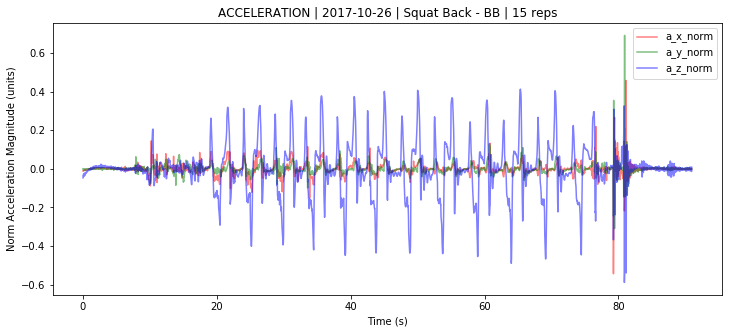

In [4]:
get_lifts = 'SELECT lift_id FROM lifts WHERE test_lift IS NOT TRUE AND lift_id > 308'
l_ids = list(pd.read_sql(get_lifts, conn)['lift_id'].values)
print sorted(l_ids, reverse=False)

# lift_id to pull
# NOTE: for dev purposes, l_ids[0] (379) is a good lift, l_ids[-1] (373) is a bad lift
lid = l_ids[0]
print 'Processing lift {}'.format(lid)

header, data = pull_data_by_lift(lid)

accel, vel, _, _, _ = process_data(header, data, RMS=False, highpass=False)
a, v, pwr, pos, force = process_data(header, data, RMS=False, highpass=True)
a_rms, _, _, _, _ = process_data(header, data, RMS=True, highpass=True)

a, v = run_norms(a, v)
print('\nAccel\n')
plot_ts(a, norm=True, stats=False)
# print('\nVel\n')
# plot_ts(v, norm=True, stats=False)

Variance of variance signal: 21.4048721973
Variance of means signal: 1.53602011324


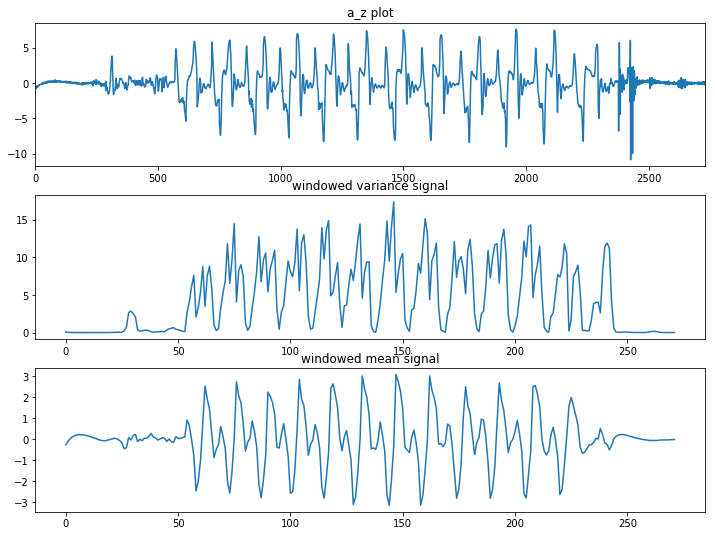

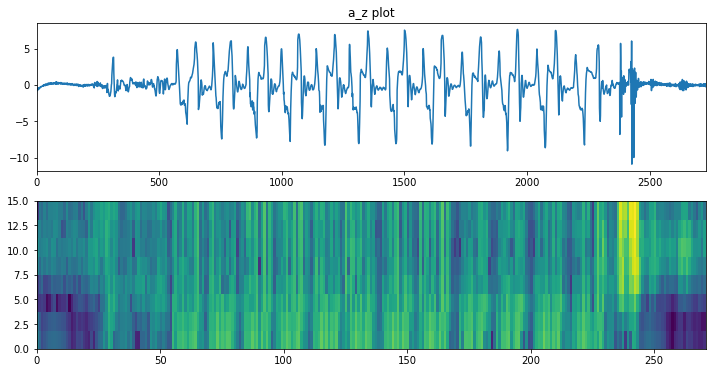

In [5]:
dat, means, variance = run_windows(a, header)
plot_windows(a, means, variance)
plot_spectral(a, dat)

In [6]:
print_stats(accel, 'a')

mean: {u'a_z': -0.387227, u'a_y': 0.053476, u'a_x': -0.12493}
var:  {u'a_z': 6.2013, u'a_y': 0.2423, u'a_x': 0.8952}
SNR:  {u'a_z': -0.1555, u'a_y': 0.1086, u'a_x': -0.132}
